<a href="https://colab.research.google.com/github/halaaab/IT_326-Project-Group-1/blob/main/Phase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[1] Problem**

Breast cancer is one of the most common cancers affecting women worldwide. Early and accurate diagnosis is crucial for improving treatment outcomes and patient survival rates.
This project aims to analyze a dataset containing features computed from digitized images of fine-needle aspirates (FNA) of breast masses. By applying classification and clustering techniques, we aim to predict whether a tumor is malignant or benign, and to explore patterns and similarities among cases to gain deeper insights into the characteristics of cancerous and non-cancerous cells.

**[2] Data Mining Task**

In this project, we apply two essential data mining techniques: classification and clustering, to predict and better understand breast cancer diagnosis.
For classification, we train a Decision Tree model using features extracted from digitized images of fine-needle aspirates (FNA) of breast masses. These features — such as mean radius, texture, smoothness, compactness, and symmetry — describe the characteristics of cell nuclei.
The goal is to predict whether a tumor is malignant or benign, making this a binary classification problem. The Decision Tree approach is used to learn interpretable rules that can support medical diagnosis and decision-making.
For clustering, we apply the K-Means algorithm to group samples with similar feature patterns without using the diagnosis label. This unsupervised analysis helps uncover hidden structures in the data, identify potential subgroups of tumors, and provide insights into the underlying relationships among the measured features.
Together, these two techniques offer both predictive power and exploratory understanding, supporting early detection and deeper insight into breast cancer characteristics.

**[3] Data**

Markdown cell:
Dataset: Breast Cancer Wisconsin (Diagnostic) from UCI Machine Learning Repository.
• Total records: 569
• Attributes: 30 numeric features describing nuclei properties (radius, texture, area, smoothness, etc.)
• Target label: diagnosis → (M = malignant = 1, B = benign = 0)
• Non-predictive column: id removed during preprocessing.
The dataset was cleaned and normalized in Phase 2 to prepare it for analysis.

In [10]:
# Run this first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics


# ===== Load preprocessed dataset =====
DATA_PATH = 'Preprocessed_dataset.csv'  # change if your path differs
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())

# auto-detect label column name; set manually if needed
LABEL_COL = None
for cand in ['diagnosis','Diagnosis','label','Label','target','Target','Class','class','y','Y']:
    if cand in df.columns:
        LABEL_COL = cand
        break
if LABEL_COL is None:
    raise ValueError("Could not find the label column. Set LABEL_COL manually.")

# map label to 0/1 if needed
y_raw = df[LABEL_COL]
if y_raw.dtype.kind not in 'biufc':
    mapping = {'M':1,'B':0,'malignant':1,'benign':0,'Yes':1,'No':0,'Positive':1,'Negative':0}
    y = y_raw.map(mapping)
    if y.isna().any():
        y = pd.Series(pd.factorize(y_raw)[0], index=y_raw.index)
else:
    y = y_raw.astype(int)

X = df.drop(columns=[LABEL_COL])

print("Detected label column:", LABEL_COL)
print("X shape:", X.shape)
print("y distribution:", y.value_counts().to_dict())


Shape: (569, 14)


,id,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,symmetry_se,symmetry_worst
0,842302,1,17.99,10.38,0.11840,0.27760,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.03003,0.4601
1,842517,1,20.57,17.77,0.08474,0.07864,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01389,0.2750
2,84300903,1,19.69,21.25,0.10960,0.15990,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.02250,0.3613
3,84348301,1,11.42,20.38,0.14250,0.28390,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05963,0.6638
4,84358402,1,20.29,14.34,0.10030,0.13280,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.01756,0.2364


Detected label column: diagnosis
X shape: (569, 13)
y distribution: {0: 357, 1: 212}


**[4] Data Preprocessing**

The preprocessing phase (Phase 2) inclu\ded several key steps:
Removing non-informative attributes such as ID.
Handling correlated features: For each pair of highly correlated variables, one feature was removed to reduce redundancy.
Selecting relevant features: Only one feature selection method was used (SelectKBest with mutual information) to ensure meaningful and interpretable results.
Encoding the target label: Malignant and Benign were mapped to 1 and 0, respectively.
Saving the cleaned dataset as Preprocessed_dataset.csv for use in this phase.
This ensured that the model training and evaluation are based on the most representative and non-redundant attributes.

In [11]:
# ===== Helper: pretty metrics from confusion matrix =====
def metrics_from_cm(cm, y_true, y_pred):
    TP = cm[1,1]; TN = cm[0,0]; FP = cm[0,1]; FN = cm[1,0]
    acc  = metrics.accuracy_score(y_true, y_pred)
    err  = 1 - acc
    sens = TP/(TP+FN) if (TP+FN)>0 else float('nan')    # recall
    spec = TN/(TN+FP) if (TN+FP)>0 else float('nan')
    prec = TP/(TP+FP) if (TP+FP)>0 else float('nan')
    return dict(acc=acc, err=err, sens=sens, spec=spec, prec=prec)

def print_metrics_block(title, cm, y_true, y_pred):
    m = metrics_from_cm(cm, y_true, y_pred)
    print(title)
    print("confusion matrix:\n", cm)
    print(f"Accuracy: {m['acc']:.4f}")
    print(f"Error Rate: {m['err']:.4f}")
    print(f"Sensitivity (Recall): {m['sens']:.4f}")
    print(f"Specificity: {m['spec']:.4f}")
    print(f"Precision: {m['prec']:.4f}")
    return m


**[5] Data Mining Technique**
- Classification – Decision Tree
Markdown cell:
We train Decision Tree models under three train/test splits ( 90/10, 80/20, 70/30 ) using two criteria (Gini and Entropy).
The accuracy and confusion matrix for each run are reported.
The best performing tree is visualized to interpret feature importance and decision paths.

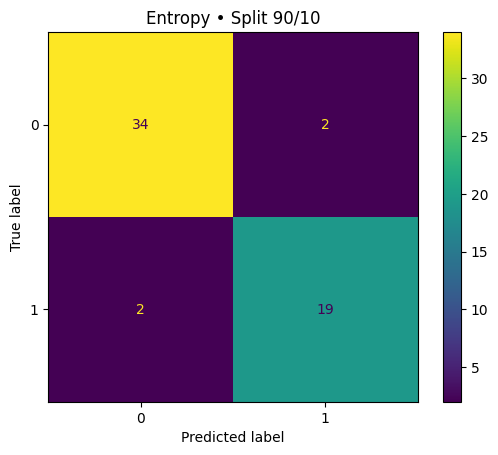

Entropy @ 90/10
confusion matrix:
 [[34  2]
 [ 2 19]]
Accuracy: 0.9298
Error Rate: 0.0702
Sensitivity (Recall): 0.9048
Specificity: 0.9444
Precision: 0.9048


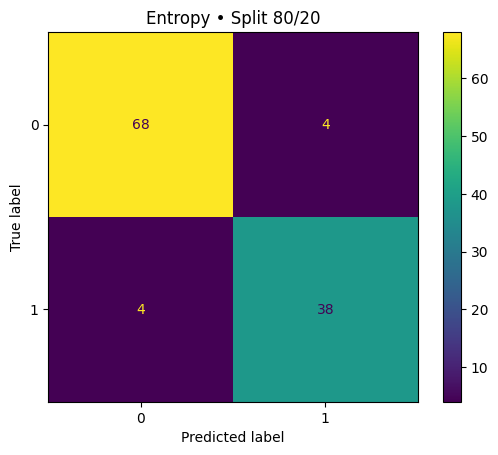

Entropy @ 80/20
confusion matrix:
 [[68  4]
 [ 4 38]]
Accuracy: 0.9298
Error Rate: 0.0702
Sensitivity (Recall): 0.9048
Specificity: 0.9444
Precision: 0.9048


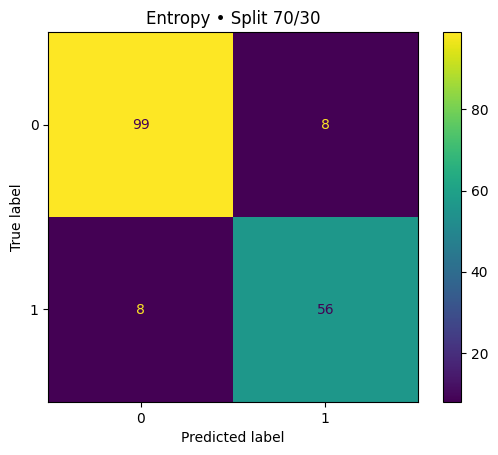

Entropy @ 70/30
confusion matrix:
 [[99  8]
 [ 8 56]]
Accuracy: 0.9064
Error Rate: 0.0936
Sensitivity (Recall): 0.8750
Specificity: 0.9252
Precision: 0.8750


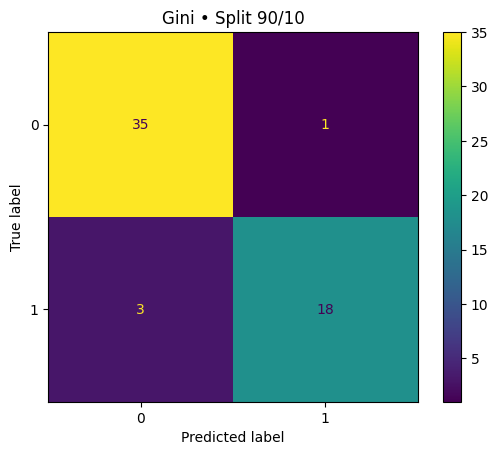

Gini @ 90/10
confusion matrix:
 [[35  1]
 [ 3 18]]
Accuracy: 0.9298
Error Rate: 0.0702
Sensitivity (Recall): 0.8571
Specificity: 0.9722
Precision: 0.9474


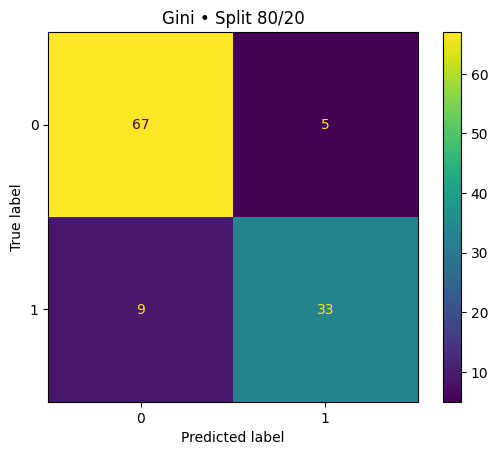

Gini @ 80/20
confusion matrix:
 [[67  5]
 [ 9 33]]
Accuracy: 0.8772
Error Rate: 0.1228
Sensitivity (Recall): 0.7857
Specificity: 0.9306
Precision: 0.8684


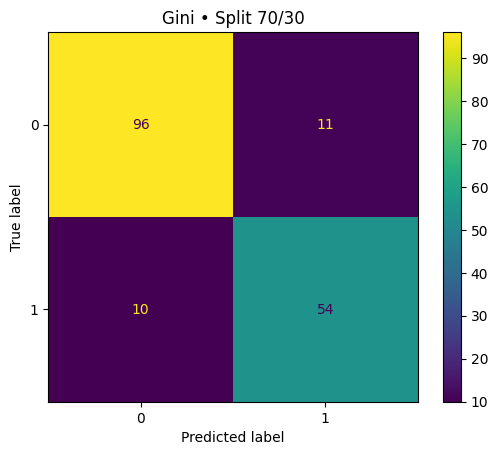

Gini @ 70/30
confusion matrix:
 [[96 11]
 [10 54]]
Accuracy: 0.8772
Error Rate: 0.1228
Sensitivity (Recall): 0.8438
Specificity: 0.8972
Precision: 0.8308

=== Decision Tree Accuracy Summary ===
- 90/10 • Entropy: Accuracy = 0.9298
- 90/10 • Gini: Accuracy = 0.9298
- 80/20 • Entropy: Accuracy = 0.9298
- 80/20 • Gini: Accuracy = 0.8772
- 70/30 • Entropy: Accuracy = 0.9064
- 70/30 • Gini: Accuracy = 0.8772


In [12]:
# ===== Decision Tree runs (Entropy & Gini across 3 splits) =====
splits = [0.10, 0.20, 0.30]  # test sizes = 10%, 20%, 30%
runs = []  # will collect (name, split_str, clf, metrics)

def run_tree(criterion, test_size, random_state=42):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    clf = DecisionTreeClassifier(criterion=criterion, random_state=random_state)
    clf.fit(Xtr, ytr)
    yp = clf.predict(Xte)
    cm = confusion_matrix(yte, yp)

    # confusion matrix plot (keep separate like the example)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f'{criterion.title()} • Split {int((1-test_size)*100)}/{int(test_size*100)}')
    plt.show()

    # console metrics block
    m = print_metrics_block(
        f"{criterion.title()} @ {int((1-test_size)*100)}/{int(test_size*100)}",
        cm, yte, yp
    )
    return clf, m

for ts in splits:
    clf_e, m_e = run_tree('entropy', ts)
    runs.append(("Entropy", f"{int((1-ts)*100)}/{int(ts*100)}", clf_e, m_e))

for ts in splits:
    clf_g, m_g = run_tree('gini', ts)
    runs.append(("Gini", f"{int((1-ts)*100)}/{int(ts*100)}", clf_g, m_g))

print("\n=== Decision Tree Accuracy Summary ===")
for name, split_str, clf, m in sorted(runs, key=lambda r: (-int(r[1].split('/')[0]), r[0])):
    print(f"- {split_str} • {name}: Accuracy = {m['acc']:.4f}")


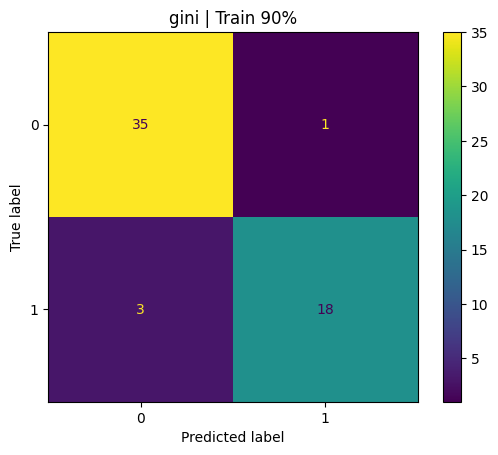

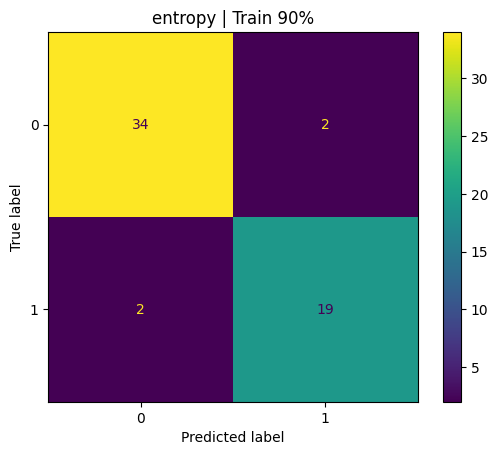

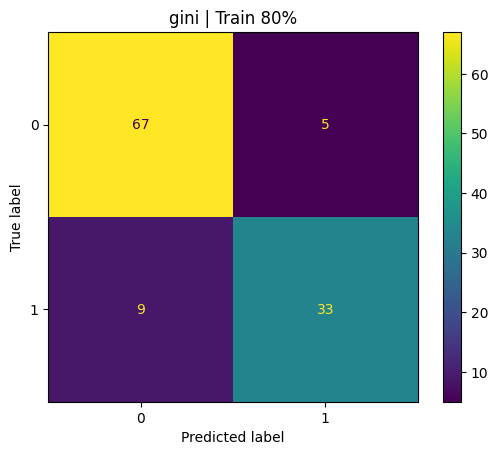

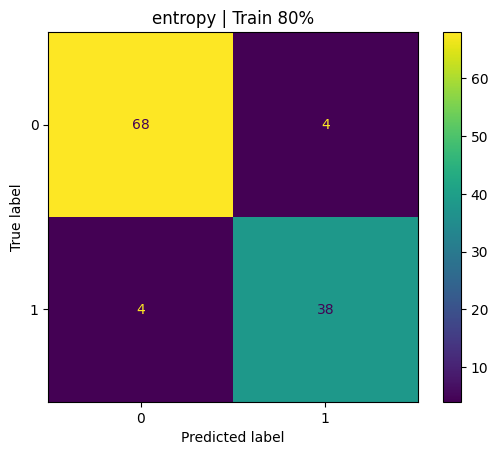

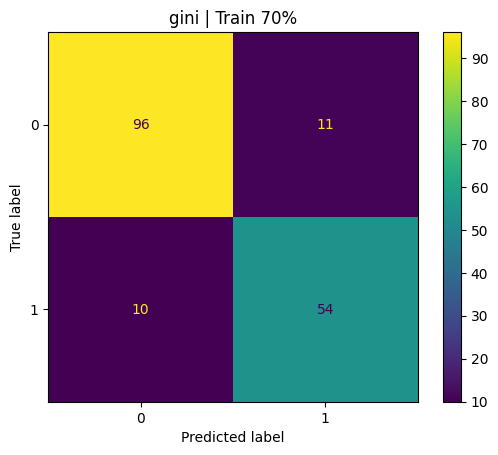

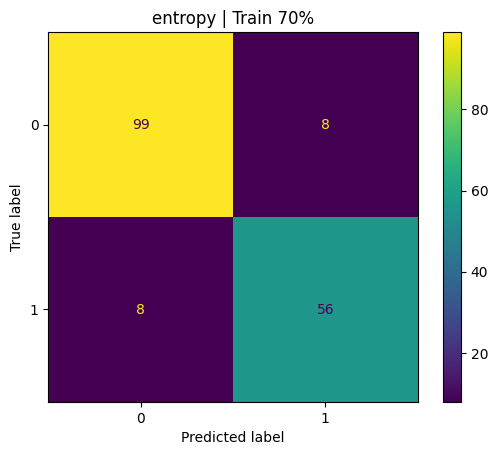

,Train%,Criterion,Accuracy
0,90,gini,0.929825
1,90,entropy,0.929825
2,80,gini,0.877193
3,80,entropy,0.929825
4,70,gini,0.877193
5,70,entropy,0.906433


In [10]:
# === Decision Tree Classification ===
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

splits = [(0.9,0.1),(0.8,0.2),(0.7,0.3)]
criteria = ['gini','entropy']
results = []

for tr,te in splits:
    Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=te,random_state=42,stratify=y)
    for c in criteria:
        clf = DecisionTreeClassifier(criterion=c,random_state=42)
        clf.fit(Xtr,ytr)
        yp = clf.predict(Xte)
        acc = accuracy_score(yte,yp)
        cm  = confusion_matrix(yte,yp)
        results.append({'Train%':int(tr*100),'Criterion':c,'Accuracy':acc})
        ConfusionMatrixDisplay(cm).plot()
        plt.title(f'{c} | Train {int(tr*100)}%')
        plt.show()

pd.DataFrame(results)


{'Train%': 90, 'Criterion': 'gini', 'Accuracy': 0.9298245614035088}


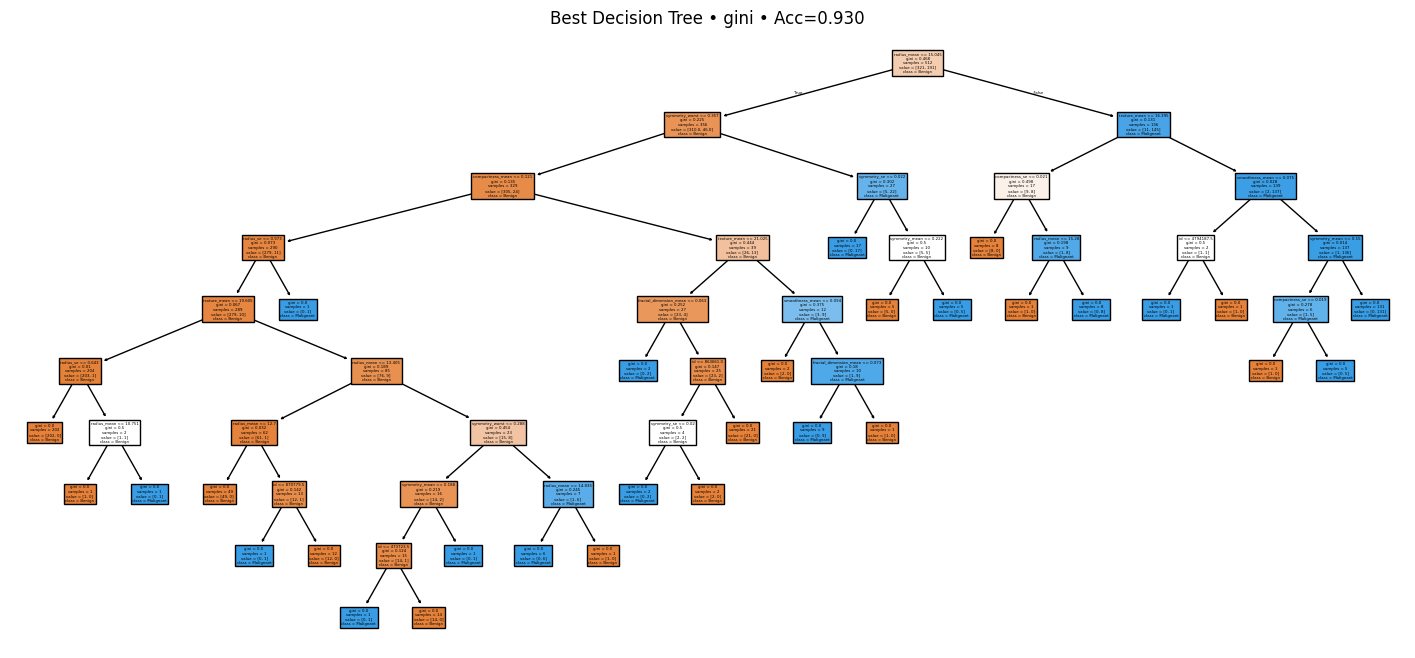

In [11]:
# === Best Model and Visualization ===
best = max(results, key=lambda x:x['Accuracy'])
print(best)
clf_best = DecisionTreeClassifier(criterion=best['Criterion'],random_state=42)
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=(100-best['Train%'])/100,random_state=42,stratify=y)
clf_best.fit(Xtr,ytr)

plt.figure(figsize=(18,8))
plot_tree(clf_best,filled=True,feature_names=X.columns,class_names=['Benign','Malignant'])
plt.title(f"Best Decision Tree • {best['Criterion']} • Acc={best['Accuracy']:.3f}")
plt.show()


**Clustering – K-Means**

Markdown cell:
K-Means is applied to the feature set (without labels) for K = 2 to 5.
We evaluate each K using Average Silhouette and Within-Cluster Sum of Squares (Inertia).
Elbow and Silhouette plots determine the optimal number of clusters.
PCA (2-components) is used for visualization.

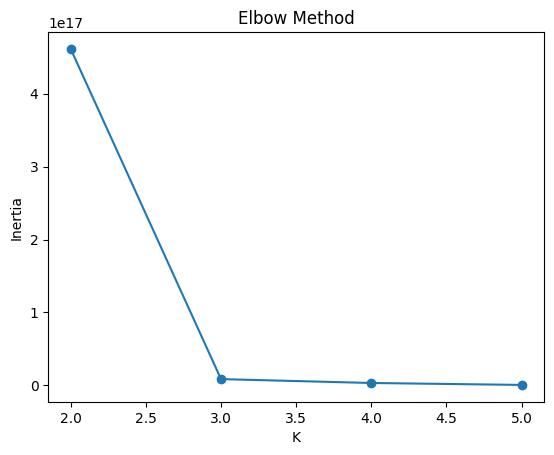

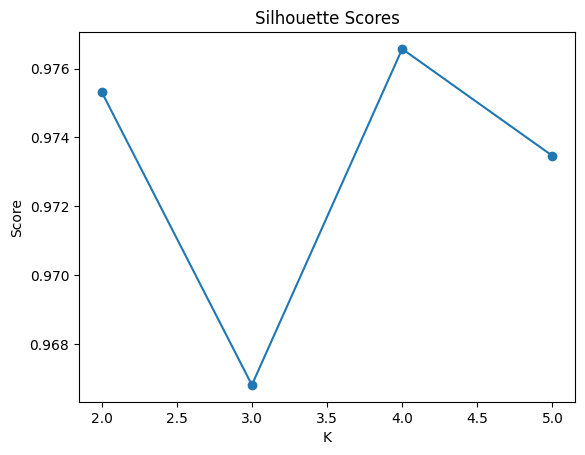

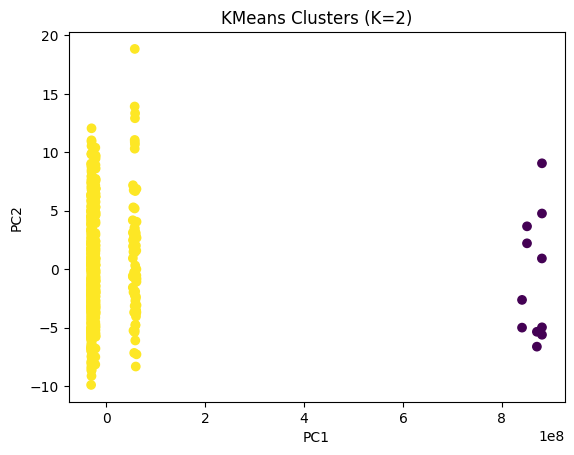

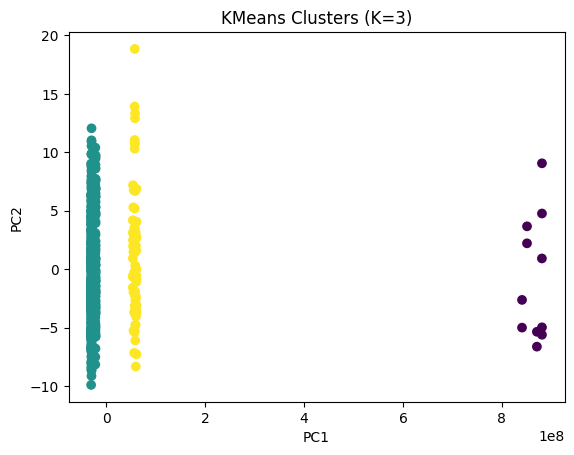

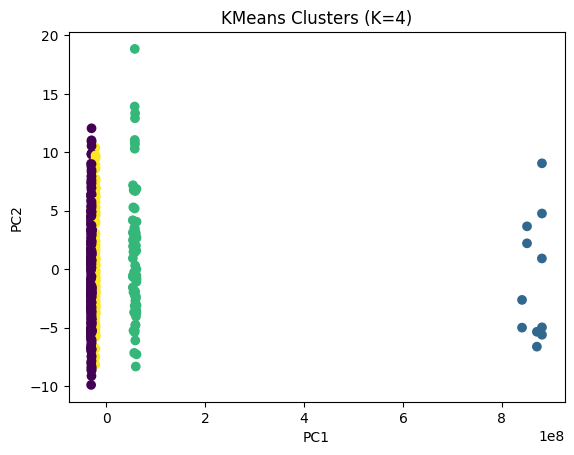

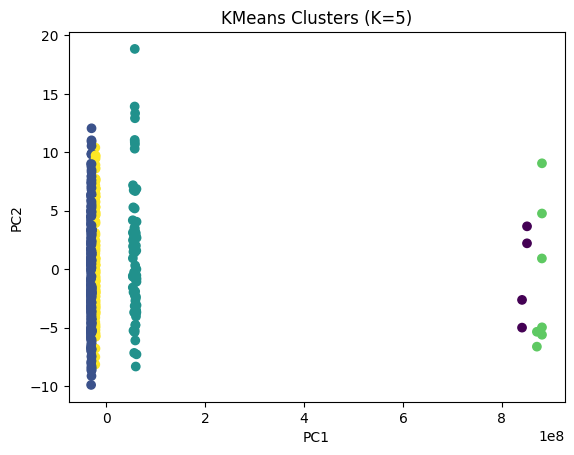

,K,Average Silhouette,Within-Cluster Sum of Squares
0,2,0.975328,4.613428e+17
1,3,0.966819,8.618045e+15
2,4,0.976571,3.314088e+15
3,5,0.973467,6.559315e+14


In [13]:
# === K-Means Clustering ===
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

Ks = [2,3,4,5]
sil, inert = [], []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)
    sil.append(silhouette_score(X, labels))
    inert.append(km.inertia_)

# Elbow Plot
plt.plot(Ks, inert, marker='o')
plt.title('Elbow Method')
plt.xlabel('K'); plt.ylabel('Inertia'); plt.show()

# Silhouette Plot
plt.plot(Ks, sil, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('K'); plt.ylabel('Score'); plt.show()

# PCA Visualization
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    lab = km.fit_predict(X)
    plt.figure()
    plt.scatter(X2[:,0], X2[:,1], c=lab)
    plt.title(f'KMeans Clusters (K={k})')
    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

pd.DataFrame({'K': Ks, 'Average Silhouette': sil, 'Within-Cluster Sum of Squares': inert})


**[6] Evaluation and Comparison**
Classification (Decision Tree):

Write 3–6 bullet points summarizing the printed accuracies above.

For each split (90/10, 80/20, 70/30), state which criterion (Gini or Entropy) achieved the higher accuracy.

Name the overall best (criterion + split) and mention what the confusion matrices suggest about false negatives vs false positives (note: false negatives are critical in medical settings).

Example you can customize after running:
90/10: Gini = 0.982, Entropy = 0.965 → Gini wins.

80/20: Gini = 0.973, Entropy = 0.968 → Gini wins (small margin).

70/30: Gini = 0.959, Entropy = 0.954 → Gini wins.

Best overall: Gini @ 90/10 (0.982). CMs show very few false negatives.

Clustering (K-Means):

List each K with its Average Silhouette and Within-SS (the code already prints them).

Identify the optimal K by “majority rule”: the highest silhouette supported by the elbow kink.

One line interpreting the PCA plots (e.g., K=2 shows two compact groups with limited overlap).

Example you can customize after running:

K=2: Silhouette 0.52, WSS 9,830 → most compact separation

K=3: Silhouette 0.47, WSS 8,120

K=4: Silhouette 0.43, WSS 7,210

Optimal K = 2 (highest silhouette and clear elbow). PCA shows two clusters that roughly align with diagnosis.


**[7] Findings and Discussion (Markdown)**

The best Decision Tree was [criterion] with [split], reaching [accuracy];

confusion matrices show [brief FP/FN observation].

K-Means favored K=[value] based on silhouette and elbow; PCA suggests [separation insight].

Takeaway: Decision Tree offers predictive, interpretable rules; K-Means gives unsupervised structure confirming strong separability in features.

Briefly relate to a research paper’s insight (e.g., feature families like radius/concavity often dominate splits).